# Clustering Mental Health in Tech Survey




## 0.1 Intent

The purpose of this notebook is to research and apply best practices for clustering discrete data. (From surveys) I will be using the data obtained from a large scale survey of the tech workforce, which asks questions about mental health in the workplace.  Upon completion I will have practiced encoding discrete and categorical data, as well as practied analysis and visualization. Most importantly, I will apply the appropriate clustering algorithm, tune hyperparameters, and measure the results. I will conclude with a brief decision tree analysis that show the key characteristic of each cluster.








## 0.2 Description of the Data

"This dataset contains the following data:

- Timestamp

- Age

- Gender

- Country

- state: If you live in the United States, which state or territory do you live in?

- self_employed: Are you self-employed?

- family_history: Do you have a family history of mental illness?

- treatment: Have you sought treatment for a mental health condition?

- work_interfere: If you have a mental health condition, do you feel that it interferes with your work?

- no_employees: How many employees does your company or organization have?

- remote_work: Do you work remotely (outside of an office) at least 50% of the time?

- tech_company: Is your employer primarily a tech company/organization?

- benefits: Does your employer provide mental health benefits?

- care_options: Do you know the options for mental health care your employer provides?

- wellness_program: Has your employer ever discussed mental health as part of an employee wellness program?

- seek_help: Does your employer provide resources to learn more about mental health issues and how to seek help?

- anonymity: Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources?

- leave: How easy is it for you to take medical leave for a mental health condition?

- mental_health_consequence: Do you think that discussing a mental health issue with your employer would have negative consequences?

- phys_health_consequence: Do you think that discussing a physical health issue with your employer would have negative consequences?

- coworkers: Would you be willing to discuss a mental health issue with your coworkers?

- supervisor: Would you be willing to discuss a mental health issue with your direct supervisor(s)?

- mental_health_interview: Would you bring up a mental health issue with a potential employer in an interview?

- phys_health_interview: Would you bring up a physical health issue with a potential employer in an interview?

- mental_vs_physical: Do you feel that your employer takes mental health as seriously as physical health?

- obs_consequence: Have you heard of or observed negative consequences for coworkers with mental health conditions in your workplace?

- comments: Any additional notes or comments"

## 0.3 Import the Dataset and Preview

This data has been obtained from the link below.

https://www.kaggle.com/osmi/mental-health-in-tech-survey/data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as  sns
import re
%matplotlib inline
plt.style.use('ggplot')
from sklearn.preprocessing import LabelEncoder

os.chdir("C:\\Users\\harri\\.kaggle\\datasets\\osmi\\mental-health-in-tech-survey")
survey = pd.read_csv('survey.csv')
survey.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


# 1. Preprocessing

## 1.1 Review of Changes to Come in EDA Section

- Threw out responses that could not be easily be categorized into "Male" and "Female". (No political commentary here, just avoiding outlier issues.)
- Threw out responses with ages such that 15 < age < 55. (Same logic.)


 ## 1.2 Removing Superfluous Data
 As they will not be useful to our clustering algorithm, we remove the Timestamp and comments columns. Later on, we will also have to remove some of our demographic info so our clustering algorithm can focus solely on the question content of the survey.

In [2]:
survey = survey.drop(["Timestamp", "comments", "state"], axis =1)

## 1.3 Check for Empty Values

We have 1209 responses left in our data. The columns with the most non-responses are Work_interfere and self_employed. (with 258 and 18 non-responses, respectively) In the case of "work_interfere" we will have to throw out the column, imputing the values would be to detrimental as we are missing nearly 30% of the data. For "self_employed" we fill in the missing answers with the most frequently seen response.

In [3]:
survey = survey.drop(["work_interfere"], axis =1)

## 1.4 Label Encoding

Since KMeans and other machine learning algorithms can only understand numerical data, we will have to convert the text answers of the survey to disctete numbers. For example yes/no becomes 1/0. To do this well takes a lot of thought, unfortunately a major limitation of the data is the inclusion of the "don't know" response in some of the survey questions. The ambiguity implicit in this answer will surely limit the effectiveness of a clustering algorithm, however, the purpose of this exerise is practice. So we push forward.

In [7]:
def encode(text):
    #Converts mispelled text into appropriate category 1=male 0=female
    text = text.lower()
    if text in ['male', 'm', 'mail', 'make','man', 'malr','mal', 'maile',]:
        text = 1
        return text
    elif text in ['f', 'female', 'femake', 'woman']:
        text = 0
        return text
    elif 'female' in text:
        text = 0
        return text
    else:
        text = 2
        return text
    
survey.Gender = survey.Gender.apply(encode)




#manually making a list to encode the data in order relative to size
encoders = dict()
enc_no_employees = {'1-5':0, '6-25':1, '26-100':2, '100-500':3, '500-1000':4, 'More than 1000':5}
surv_no_employees = survey.no_employees.apply(lambda row: enc_no_employees[row])

#same as above, but for the leave column
enc_leave = {'Somewhat easy':3, "Don't know":2, 'Somewhat difficult':1,
       'Very difficult':0, 'Very easy':4}
surv_leave = survey.leave.apply(lambda row: enc_leave[row])

#encode the other columns
for x in range(2,23):
    encoders['le'+str(x-2)]= LabelEncoder()
    survey.iloc[:,x] = encoders['le'+str(x-2)].fit_transform(survey.iloc[:,x].astype(str))

#Replace sklearns unordered encoding with the in-order encoding developed above.
survey['leave'] = surv_leave
survey['no_employees'] = surv_no_employees
survey.head()

,Age,Gender,Country,self_employed,family_history,treatment,no_employees,remote_work,tech_company,benefits,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,0,44,2,0,1,1,0,1,2,...,2,3,1,1,1,2,1,0,2,0
1,44,1,44,2,0,0,5,0,0,0,...,0,2,0,1,0,0,1,1,0,0
2,32,1,6,2,0,0,1,0,1,1,...,0,1,1,1,2,2,2,2,1,0
3,31,1,43,2,1,1,2,0,1,1,...,1,1,2,2,1,0,0,0,1,1
4,31,1,44,2,0,0,3,1,1,2,...,0,2,1,1,1,2,2,2,0,0


Now that we have encoded our data, we can finish the section above by imputing the "self_employed" column. (We never did that)

In [8]:
from sklearn.preprocessing import Imputer

#Replace NaN values in the self_employed column
labels = survey.columns
imp = Imputer(strategy = 'most_frequent')
survey = pd.DataFrame(imp.fit_transform(survey), columns = labels)

Beautiful. We have no missing values. Data that is encoded numerically in a way that more contextually similar answers are closer together in euclidean space. We should be good to go for clustering.

# 2. EDA: Demographic Info

## 2.1 Gender of Respondents


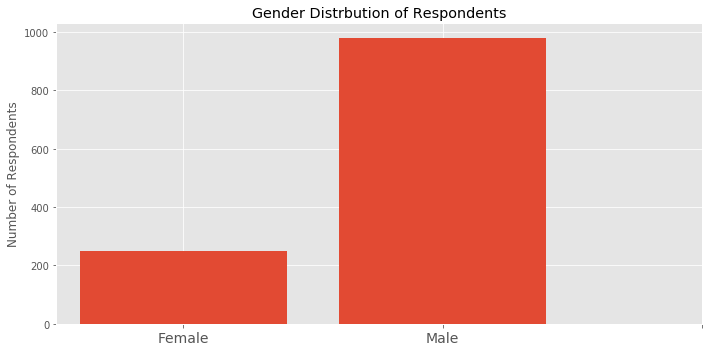

In [4]:
survey = survey[survey.Gender != 2]
plt.figure(figsize = (10,5))
plt.bar(survey.Gender.value_counts().index, survey.Gender.value_counts())
xticks = plt.gca()
plt.xticks([0,1,2], ['Female','Male'])
plt.gca().set_xticklabels(['Female', 'Male'], fontsize = 14)
plt.title('Gender Distrbution of Respondents')
plt.ylabel('Number of Respondents')
plt.tight_layout()
plt.show()

## 2.2 Age Distribution of Respondents

We have removed responses with age less than 15 and greater than 55. Removal of outliers will make clustering easier as we continue. The average age of respondents is 35. 

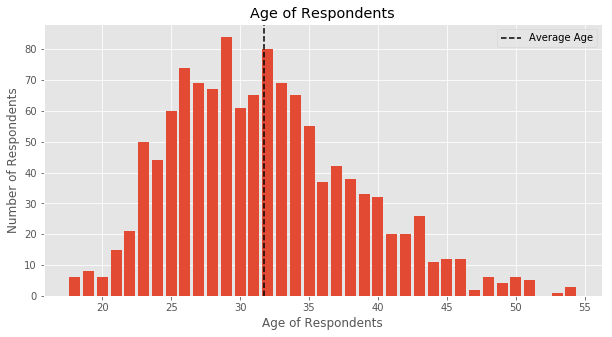

In [5]:
survey = survey[survey.Age>15]
survey = survey[survey.Age<55]

plt.figure(figsize =(10,5))
survey.Age.value_counts()
plt.bar(survey.Age.value_counts().index, survey.Age.value_counts())
plt.title('Age of Respondents')
plt.ylabel('Number of Respondents')
plt.xlabel('Age of Respondents')
av_age = np.mean(survey.Age)
plt.axvline(av_age,
           color = 'black',
           linestyle = '-',
            linewidth=4,
            label='Average Age')
plt.legend()
plt.show()

## 2.3 Nationality of Respondents
Around 60% or respondents came from the US, and another 14% comes from the UK. 

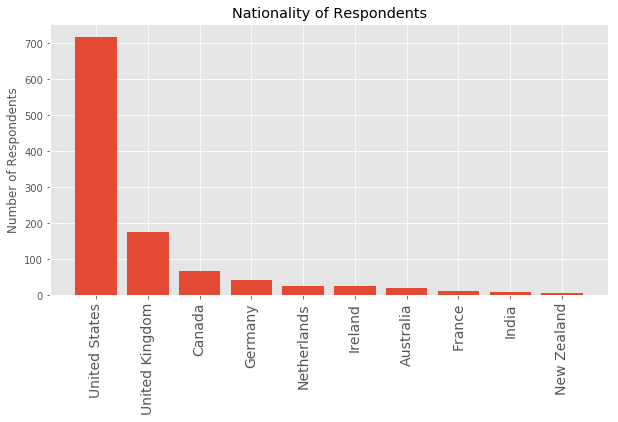

In [6]:
plt.figure(figsize =(10,5))
plt.bar(survey.Country.value_counts().index[0:10], survey.Country.value_counts()[0:10])
plt.title('Nationality of Respondents')
plt.ylabel('Number of Respondents')
plt.gca().set_xticklabels(survey.Country.value_counts().index[0:10],rotation =90, fontsize = 14)
plt.show()

## 2.4 Conclusion

As we continue on to the actual clustering of the data, we are going to remove the Country, Gender and Age column from our data. The reason behind this decision, is that categorical variables like Country, add to much complexity to the model. I might be able to come up with smarter features through some feature engineering, but the effort would outweigh the gain.

In [9]:
survey = survey.drop(["Age", "Gender",], axis = 1)
survey = survey.drop(["Country"], axis =1)

# 3. Clustering without PCA




In this section I go about the clustering process with the KMeans and Agglomerative Clustering algorithms. In the next section we will reduce the dimensionality of the feature space. For now we are imputing the entirety of our data in each algorithm and looking for an appropriate number of clusters, using metrics and visualizations.

In [77]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN #For clustering
from matplotlib import cm
from sklearn.metrics import silhouette_samples, silhouette_score


def inertia_plot( X, start = 2, stop = 10):
    #A simple inertia plotter to decide K in KMeans
    inertia = []
    for x in range(start,stop):
        clust = KMeans(n_clusters = x)
        labels = clust_predict(X)
        inertia.append(clust.inertia_)
    plt.figure(figsize = (10,6))
    plt.plot(range(start,stop), inertia, marker = 'o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Inertia Decrease with K')
    plt.xticks(list(range(start, stop)))
    plt.show()

def silh_samp_cluster(clust,  X, start=2, stop=5, metric = 'euclidean', gauss=False):
    # Taken from sebastian Raschkas book Python Machine Learning second edition
    for x in range(start, stop):
        if gauss:
            km=clust.set_params(n_components=x)
            y_km = km.fit(X).predict(X)
        else:
            km=clust.set_params(n_clusters=x)
            y_km = km.fit_predict(X)
        cluster_labels = np.unique(y_km)
        n_clusters = cluster_labels.shape[0]
        silhouette_vals = silhouette_samples(X, y_km, metric = metric)
        y_ax_lower, y_ax_upper =0,0
        yticks = []
        for i, c in enumerate(cluster_labels):
            c_silhouette_vals = silhouette_vals[y_km == c]
            c_silhouette_vals.sort()
            y_ax_upper += len(c_silhouette_vals)
            color = cm.jet(float(i)/n_clusters)
            plt.barh(range(y_ax_lower, y_ax_upper),
                    c_silhouette_vals,
                    height=1.0,
                    edgecolor='none',
                    color = color)
            yticks.append((y_ax_lower + y_ax_upper)/2.)
            y_ax_lower+= len(c_silhouette_vals)
            
        silhouette_avg = np.mean(silhouette_vals)
        plt.axvline(silhouette_avg,
                   color = 'red',
                   linestyle = "--")
        plt.yticks(yticks, cluster_labels+1)
        plt.ylabel("cluster")
        plt.xlabel('Silhouette Coefficient')
        plt.title('Silhouette for ' + str(x) + " Clusters")
        plt.show()
        
def silh_scores(clus, survey, start = 2, stop =8, gauss=False):    
    for x in range(start, stop):
        if gauss:
            km = clus.set_params(n_components=x)
            label = km.fit(survey).predict(survey)
        else:
            km=clus.set_params(n_clusters=x)
            label = km.fit_predict(survey)
        print('Silhouette-Score for', x,  'Clusters: ', silhouette_score(survey, label))

## 3.1 K-Means and Clustering Metrics


### 3.1.1 Inertia Plot
 Below is a plot of the KMeans inertia decrease as we increase the number of clusters. Remember we want our inertia to be LOW. A low inertia means we have clustered our data well. Since there is no hard elbow, we minght pick a good number of clusters to be 5. 

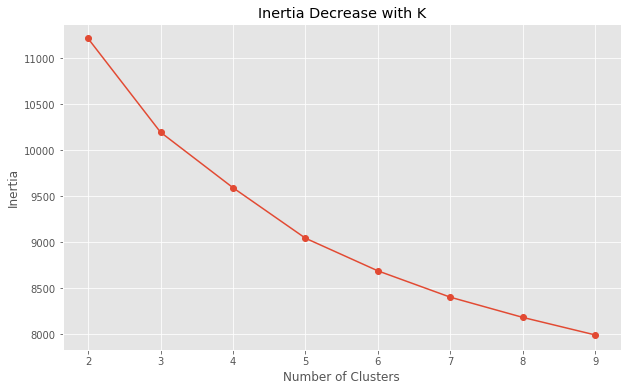

In [35]:
inertia_plot( survey)

### 3.1.2 Silhouette Scores
Next we have silhouette scores for different numbers of clusters. A score of -1 means poor clustering, 0 means cluster overrlap, and 1 means good clusterning. (good clustering is tightly packed clusters that are far away from each other.)

In [56]:
silh_scores(KMeans, survey, start =4 )

Silhouette-Score for 4 Clusters:  0.12028233397251088
Silhouette-Score for 5 Clusters:  0.11662060382431941
Silhouette-Score for 6 Clusters:  0.1174957815503735
Silhouette-Score for 7 Clusters:  0.10696096898626849


### 3.1.3 Silhouette Plots
Latly we have silhouette plots which are the silhouette scores of every sample within each cluster. Note that imbalanced clusters lead to wider bars. Samples with higher spectrall coefficient are close to their cluster mates, and far from their neighbors in other clusters

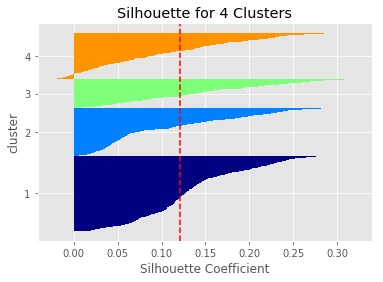

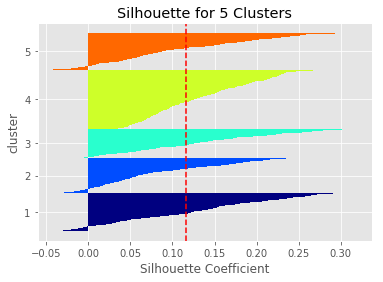

In [57]:
silh_samp_cluster(KMeans, survey, start =4, stop =6)

### 3.1.4 Conclusion
Not great. We have a low average inertia,  low silhouette scrores, and a high variance in the silhouette plots. Lets try agglomerative clustering

## 3.2 Agglomerative Clustering

### 3.2.1 Silhouette Scores
As opposed to KMeans, here we see a much sharper drop off as we increase the number of clusters.

In [61]:
silh_scores(AgglomerativeClustering, survey, start = 4)

Silhouette-Score for 4 Clusters:  0.09979111096256836
Silhouette-Score for 5 Clusters:  0.08727975194310092
Silhouette-Score for 6 Clusters:  0.08760098945117002
Silhouette-Score for 7 Clusters:  0.08980342970987766


### 3.2.2 Silhouette Plots
Recall that bad clustering results in a silhouette score close to -1. In the plots below, the leftward facing spikes are samples that were clustered very poorly.

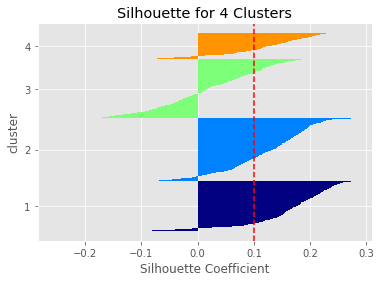

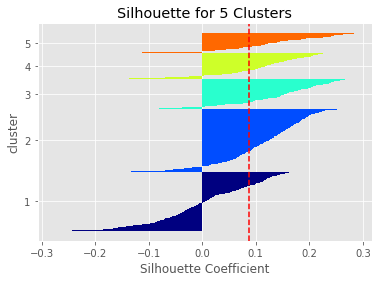

In [64]:
silh_samp_cluster(AgglomerativeClustering, survey, start = 4, stop =6)

### 3.2.3 Conclusion
Aggl. Clustering performed worse than KMeans, the silhouette plots actually show high variance clusters, and very poor clustering for some samples as the number of clusters increases. (See the left-facing spikes in the graphs above, these are groups of poorly clustered samples).

# 4. Clustering with PCA

## 4.1 Choosing the Number of Components: Explained Variance

Below is a plot of the explained variance in the data as we vary the number of principal components. Ideally we would want this kind of plot to look more "elbowy" with a small number of prinipal components explaining a majority of the data. 

We may be able to boost the effectiveness of our clustering by projecting the data down to 11 components. We see in the graph below that at 11 components we have explained 90% of the variance, with diminishing returns afterward. This will be the number  of components we use going forward.

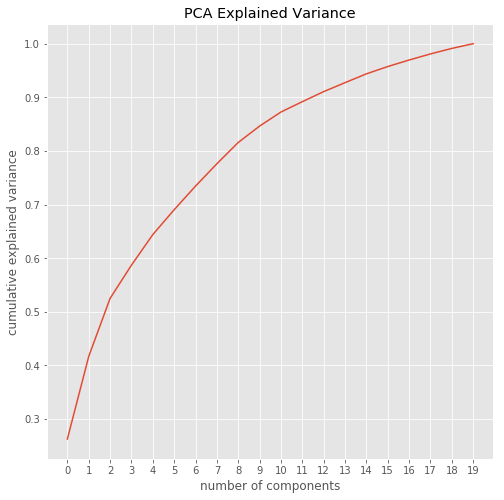

In [16]:
from sklearn.decomposition import PCA

plt.figure(figsize=(8, 8))
pca = PCA().fit(survey)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.title('PCA Explained Variance')
plt.xticks(list(range(20)), list(range(20)))
plt.show()


##  4.2 KMeans with PCA

As we explained above, we will be looking at metrics for KMeans with 11 principal components. 

### 4.2.1 Inertia Plot (11 Principal Components)

The below plot shows lower average inertia than our previous clustering model. The elbow of the graph appears to be between 5 and 7 clusters. 

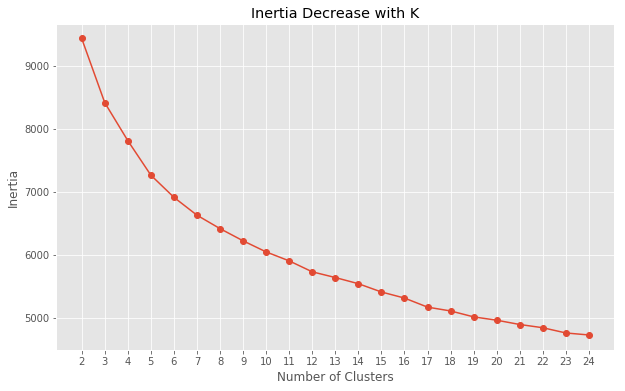

In [17]:
survey_p = PCA(n_components=11).fit_transform(survey)
inertia_plot(KMeans, survey_p,stop =25)

### 4.2.2 Silhouette Plots
As we see below, the average silhouette score seems to be about even for 5 and 6 clusters. With a preference towards a simppler model, we will choose 5 clusters for our final model.

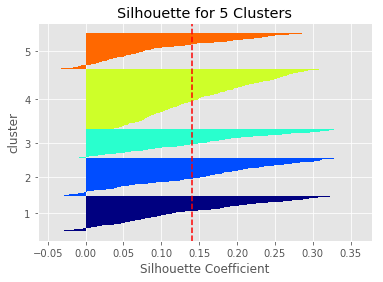

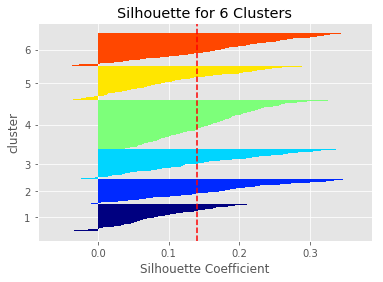

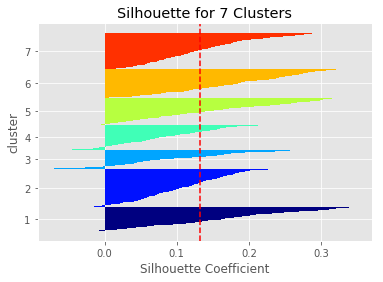

In [18]:
silh_samp_cluster(KMeans, survey_p, start =5, stop =8)

# 5. Fun Visualizations

This section is totally skipable, I just wanted to see what this data looked like in 2D and 3D.

## 5.1 Visualizing in 2 Dimensions
Lets visualize a scatterplot with 2 principal components, and 5 clusters determined with the KMeans Algorithm

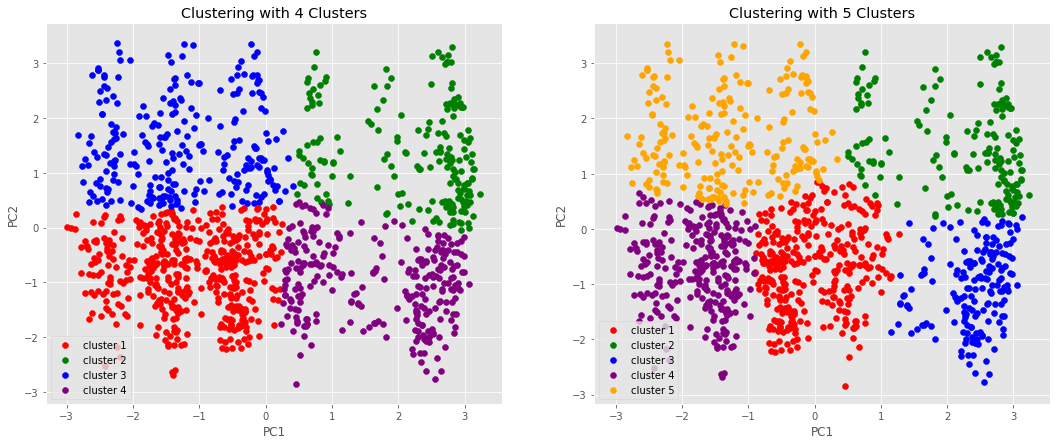

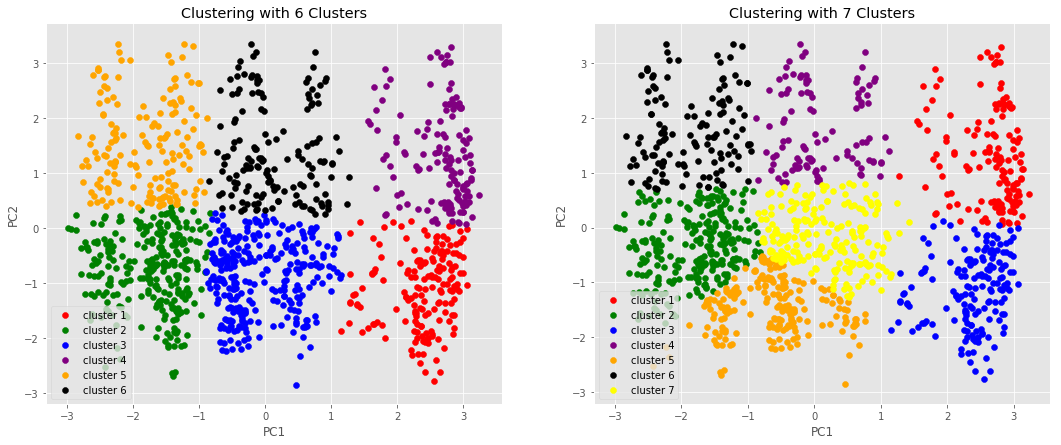

In [41]:
def make_preds(clust, survey, n_clusters = 4, PCA_val=2):
    #Perform PCA and combine predictions with data.
    survey_p = pd.DataFrame(PCA(n_components = PCA_val).fit_transform(survey))   
    preds = pd.Series(clust(n_clusters = n_clusters,).fit(survey_p).predict(survey_p))
    survey_p = pd.concat([survey_p, preds], axis =1)
    survey_p.columns = list(range(PCA_val))+['target']
    return survey_p

def rowplot(clust, survey, start =4, stop=5):
    #Makes 2 plots on a row
    fig = plt.figure(figsize = (18, 7))
    colors = ['red', 'green', 'blue', 'purple', 'orange', 'black', 'yellow', 'magenta','cyan']
    for i in range(start, stop+1):
        survey_p = make_preds(KMeans, survey, n_clusters = i)
        plt.subplot(121+(i-start))
        for x in range(i):
            plt.scatter(survey_p[survey_p['target']==x].iloc[:,0], survey_p[survey_p.target==x].iloc[:,1], c = colors[x], label = 'cluster '+str(x+1))
            plt.title('Clustering with '+str(i)+ ' Clusters')
            plt.legend()
            plt.xlabel('PC1')
            plt.ylabel('PC2')

def pca_plot(clust, survey, start =4, stop =5):
    #plots the required number of plots
    i=0
    for y in range(start, stop+1):
        if i%2==0:
            rowplot(clust, survey, start=y, stop = y+1)
            plt.show()
            i+=1
        else:
            i+=1
            continue

pca_plot(KMeans, survey, 4, 7)

## 5.2 Visualizing in 3 Dimensions
Now with 3 Principal Components

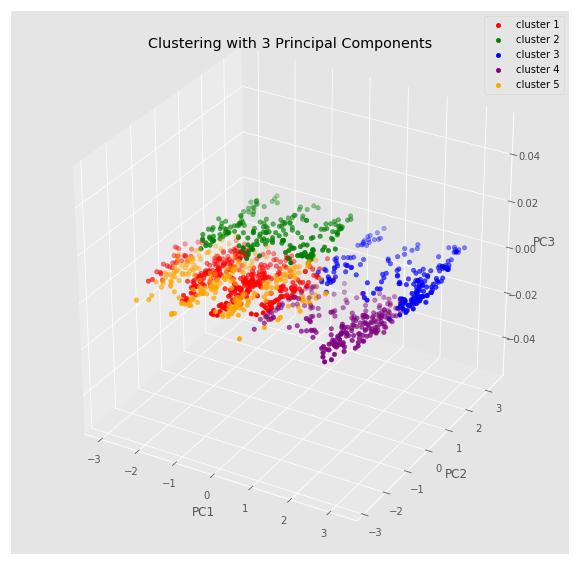

In [20]:
from mpl_toolkits.mplot3d import Axes3D

def pca3dplot(clust, survey, n_clusters=5):
    survey_p3 = make_preds(KMeans, survey, n_clusters=n_clusters, PCA_val=3)
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111, projection='3d')
    colors = ['red', 'green', 'blue', 'purple', 'orange', 'black', 'yellow', 'magenta','cyan']
    for x in range(n_clusters):
        ax.scatter(survey_p3[survey_p3['target']==x].iloc[:,0], survey_p3[survey_p3.target==x].iloc[:,1], c = colors[x], label = 'cluster '+str(x+1))
    plt.legend()
    plt.title('Clustering with 3 Principal Components')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.gca().set_zlabel('PC3')
    plt.show()
    
pca3dplot(KMeans, survey)
KMeans()

## 5.3 Conclusion



# 6 Project Conclusion

We practiced our data preprocessing. We looked at different metrics for evaluating how good the clustering was like silhouette scores and inertia. Then we found that the best clustering models were generally once we reduced the data down to two dimenstions and searched for 4-5 clusters in the data. 

Due to the limitations of the data, clustering was less than optimal, but in the future we will know what to look for when we consider clustering a new dataset!